# Dropout

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

True


## Data Preparation

In [3]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 50

NAME = "Dropout"

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

In [4]:
class DropoutNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 500)
        self.l2 = nn.Linear(500, 500)
        self.l3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = self.dropout(x)
        x = F.relu(self.l1(x))
        x = self.dropout(x)
        x = F.relu(self.l2(x))
        x = self.dropout(x)
        x = self.l3(x)
        return x

net = DropoutNetwork().to(DEVICE)

## Training

In [5]:
def save_training_viz(train_hist, epoch):
    plt.figure(figsize=(10,9))
    plt.plot(train_hist,'b', label="training loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'./{NAME}_{epoch}_training.png')

In [6]:
train_loss = []
def train(net, optimizer, objective, epoch):
    net.train()
    pbar = tqdm(train_loader)
    running_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        outputs = net(data)
        loss = objective(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        pbar.set_description(f"Epoch {epoch} | Running loss = {round(float(running_loss/len(train_loader)),3):.3f} | ")
    train_loss.append(float(running_loss/len(train_loader)))
    save_training_viz(train_loss,epoch+1)
    torch.save(net, f'{NAME}_{epoch}_{round(float(running_loss/len(train_loader)),3)}.pth')


Epoch 0 | Running loss = 1.070 | : 100%|██████████| 600/600 [00:12<00:00, 47.63it/s] 
Epoch 1 | Running loss = 0.542 | : 100%|██████████| 600/600 [00:08<00:00, 72.98it/s] 
Epoch 2 | Running loss = 0.457 | : 100%|██████████| 600/600 [00:09<00:00, 62.95it/s]
Epoch 3 | Running loss = 0.403 | : 100%|██████████| 600/600 [00:10<00:00, 56.75it/s]
Epoch 4 | Running loss = 0.360 | : 100%|██████████| 600/600 [00:08<00:00, 68.62it/s] 
Epoch 5 | Running loss = 0.325 | : 100%|██████████| 600/600 [00:08<00:00, 74.57it/s] 
Epoch 6 | Running loss = 0.303 | : 100%|██████████| 600/600 [00:07<00:00, 75.69it/s] 
Epoch 7 | Running loss = 0.280 | : 100%|██████████| 600/600 [00:08<00:00, 73.47it/s] 
Epoch 8 | Running loss = 0.265 | : 100%|██████████| 600/600 [00:08<00:00, 74.71it/s] 
Epoch 9 | Running loss = 0.248 | : 100%|██████████| 600/600 [00:07<00:00, 82.43it/s] 
Epoch 10 | Running loss = 0.237 | : 100%|██████████| 600/600 [00:08<00:00, 73.91it/s] 
Epoch 11 | Running loss = 0.226 | : 100%|██████████| 60

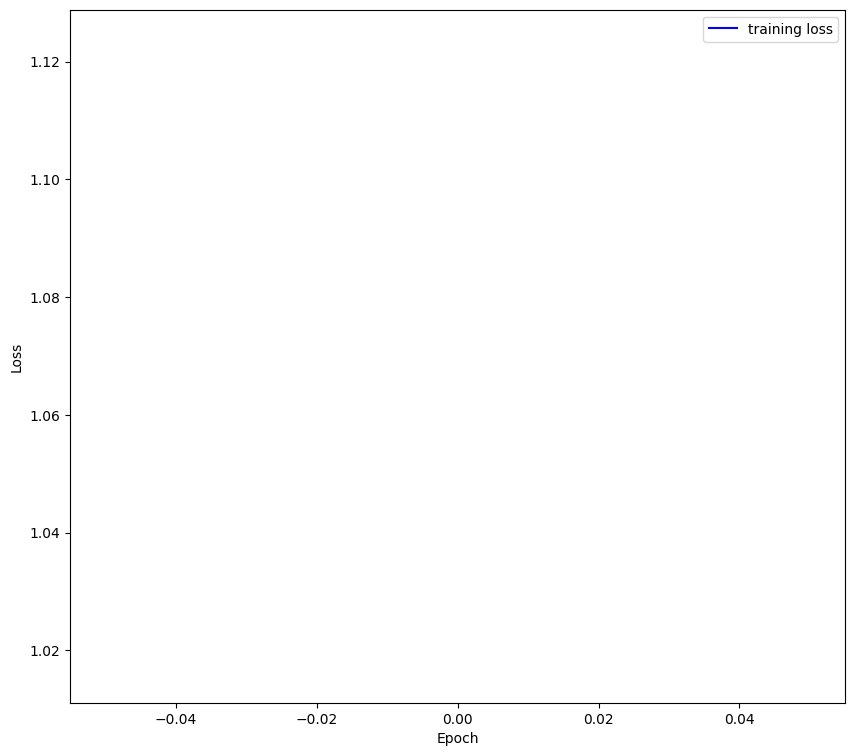

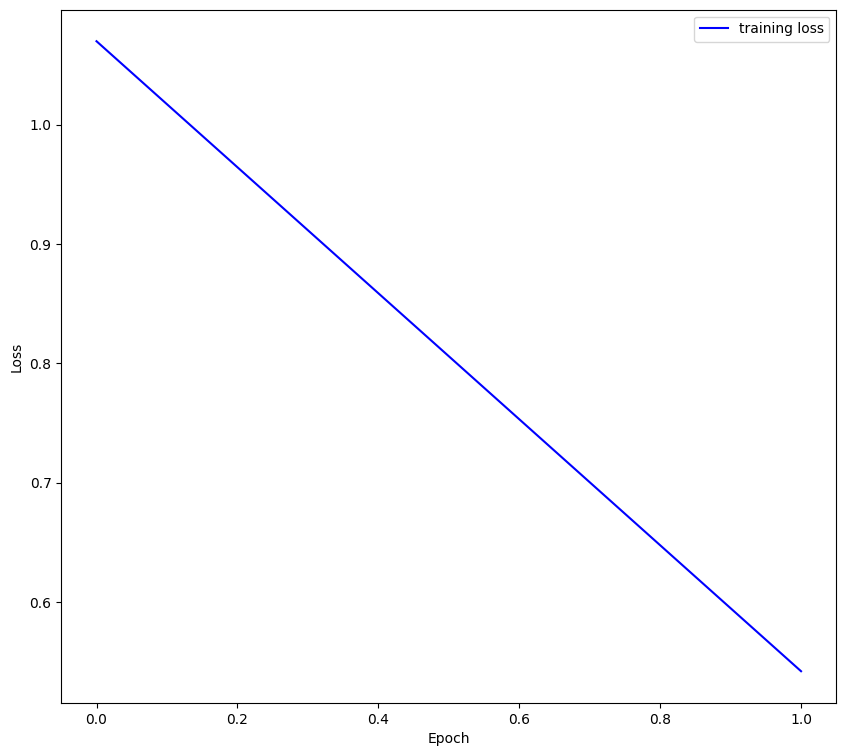

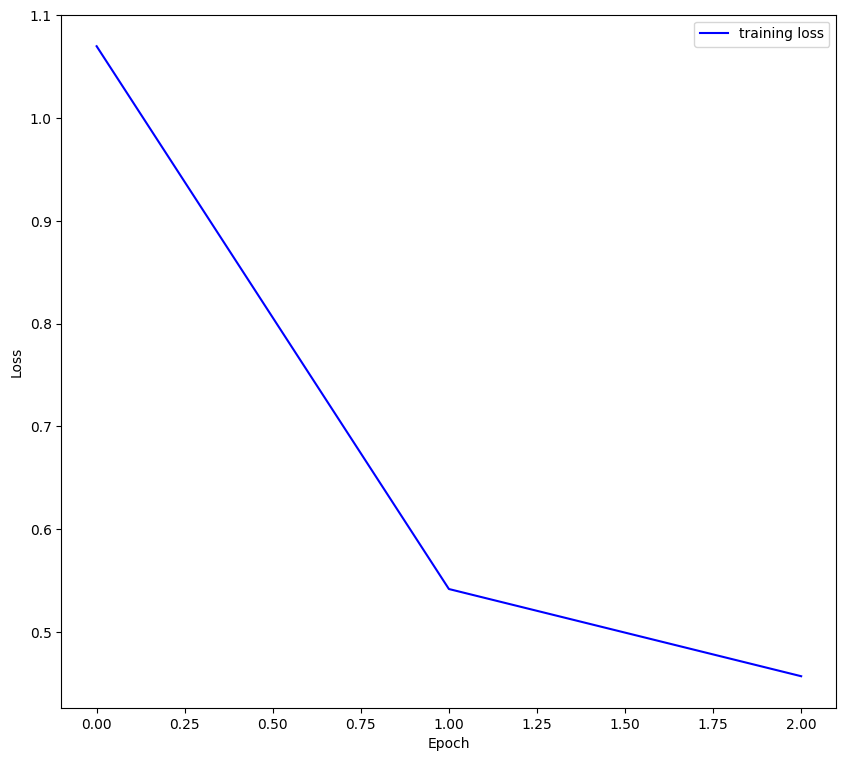

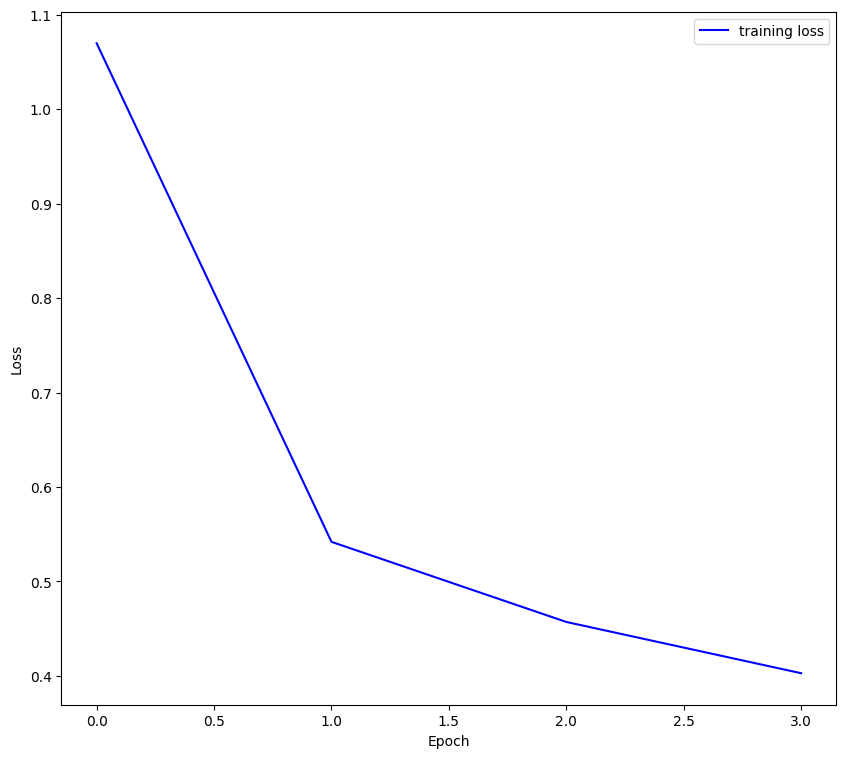

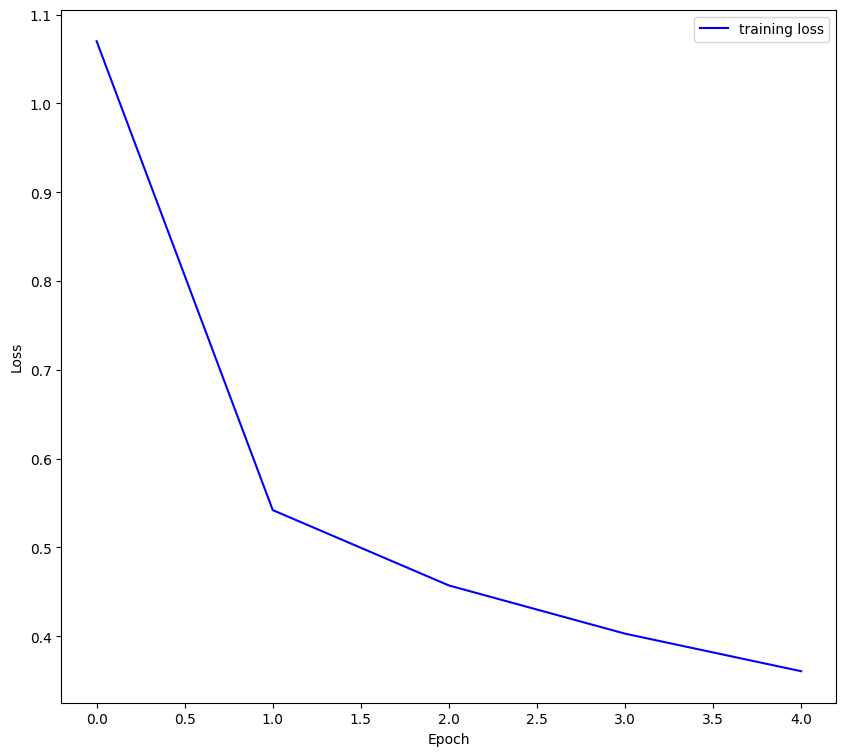

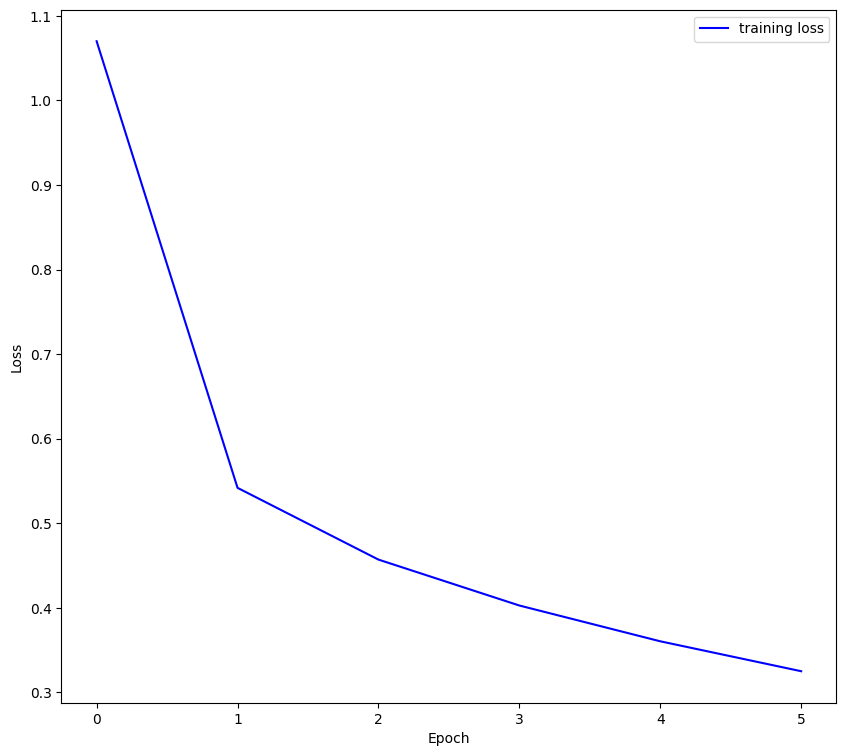

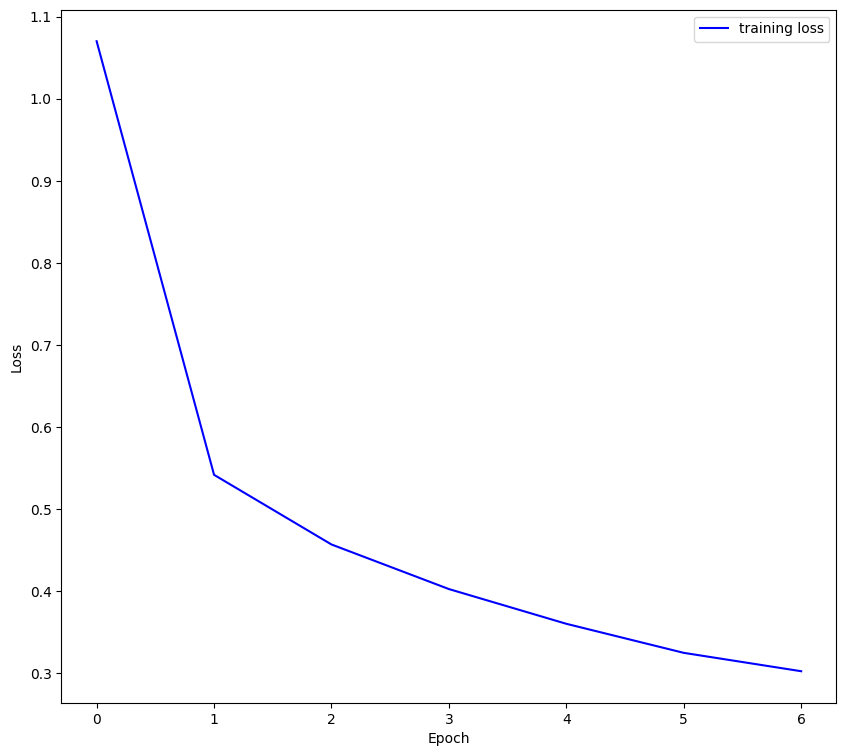

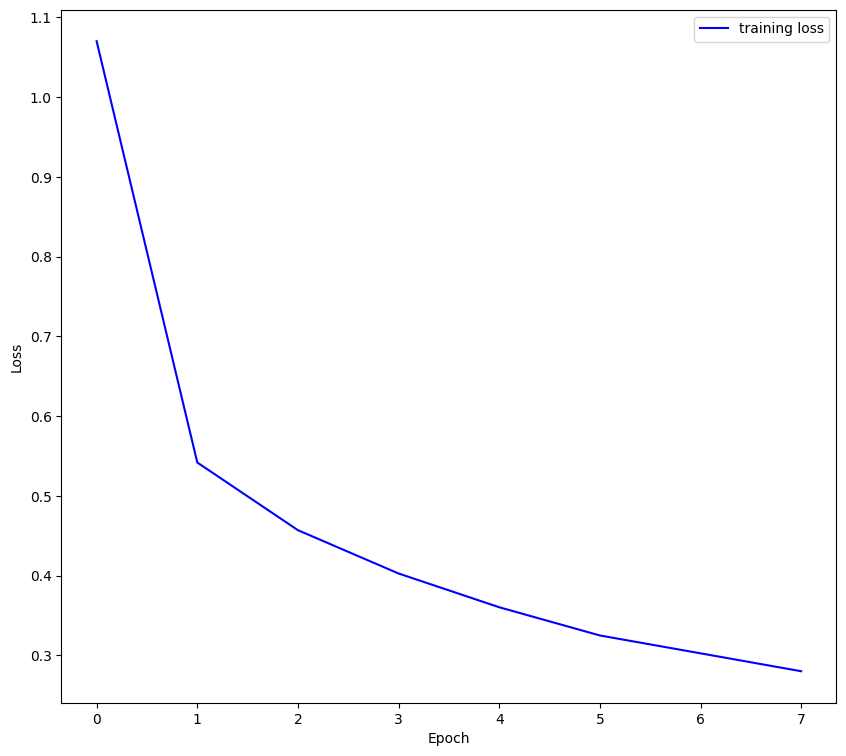

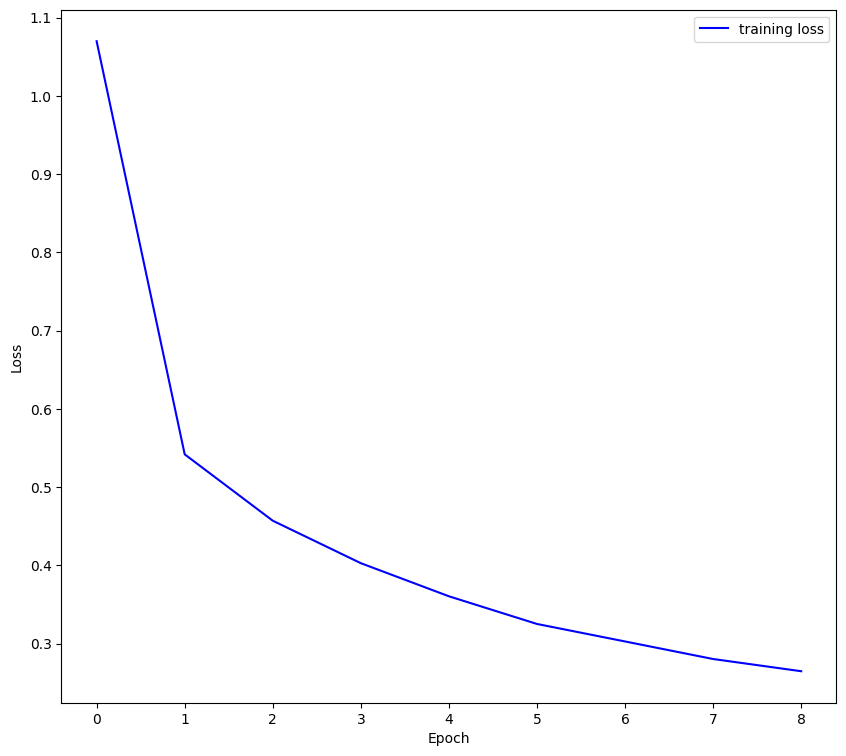

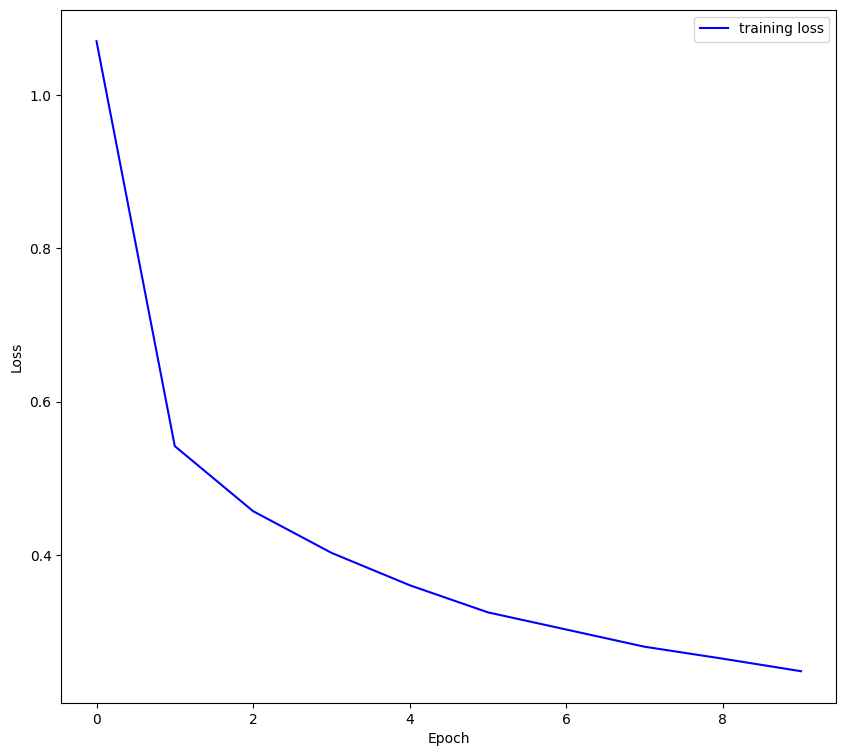

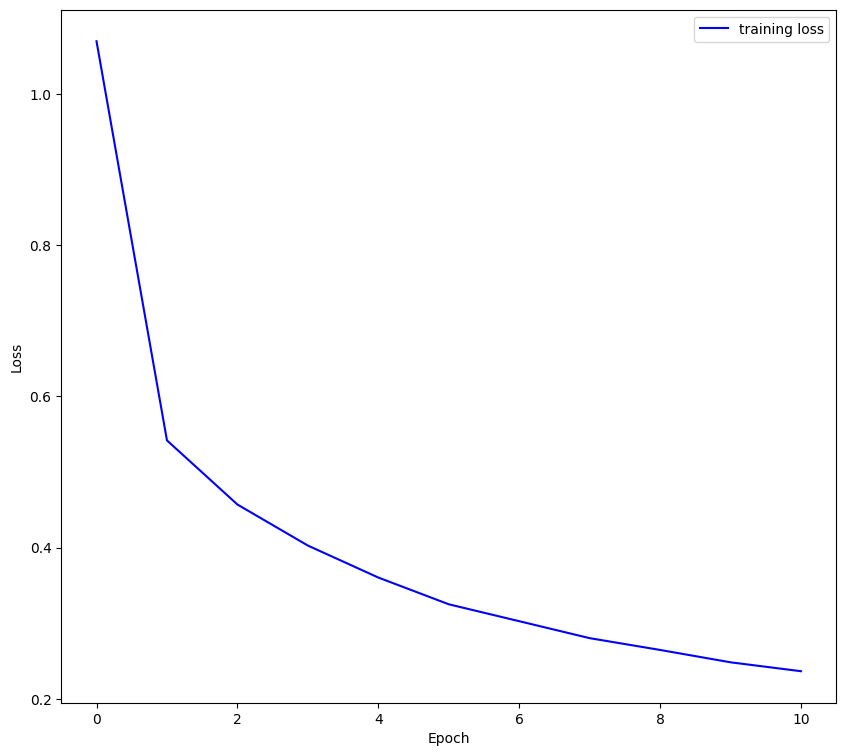

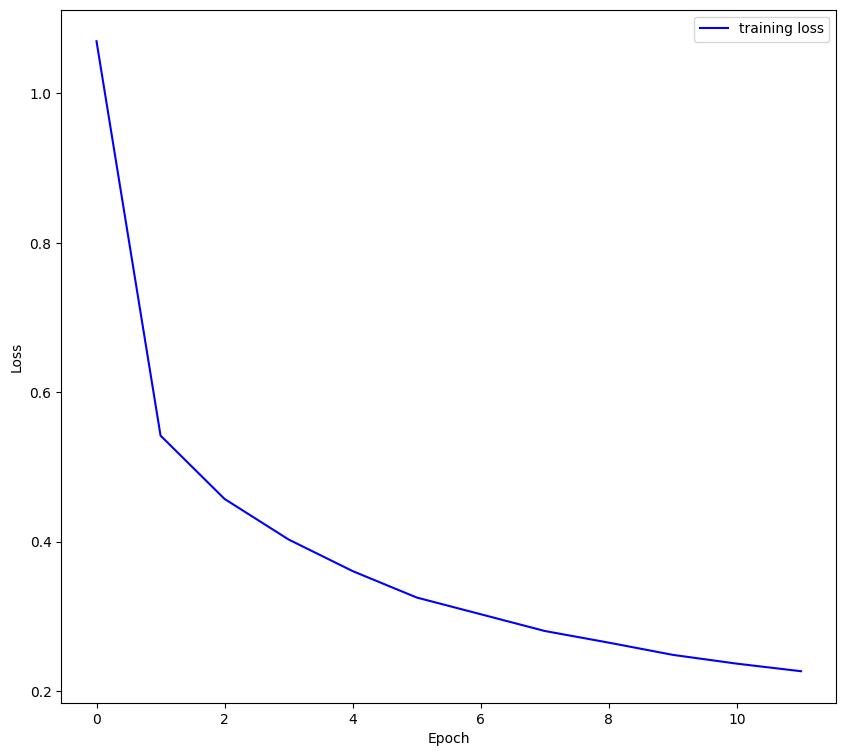

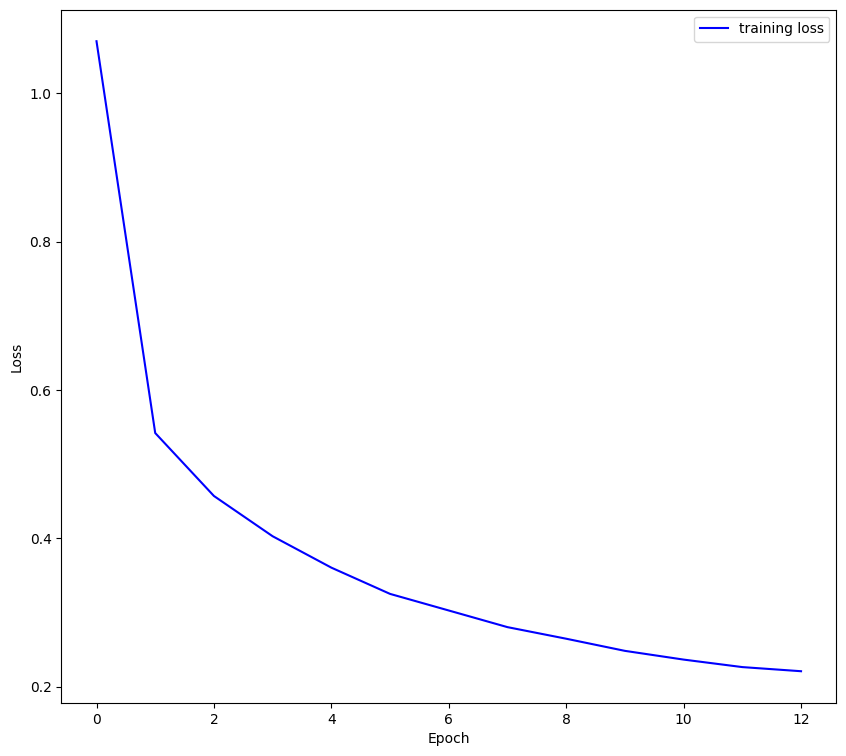

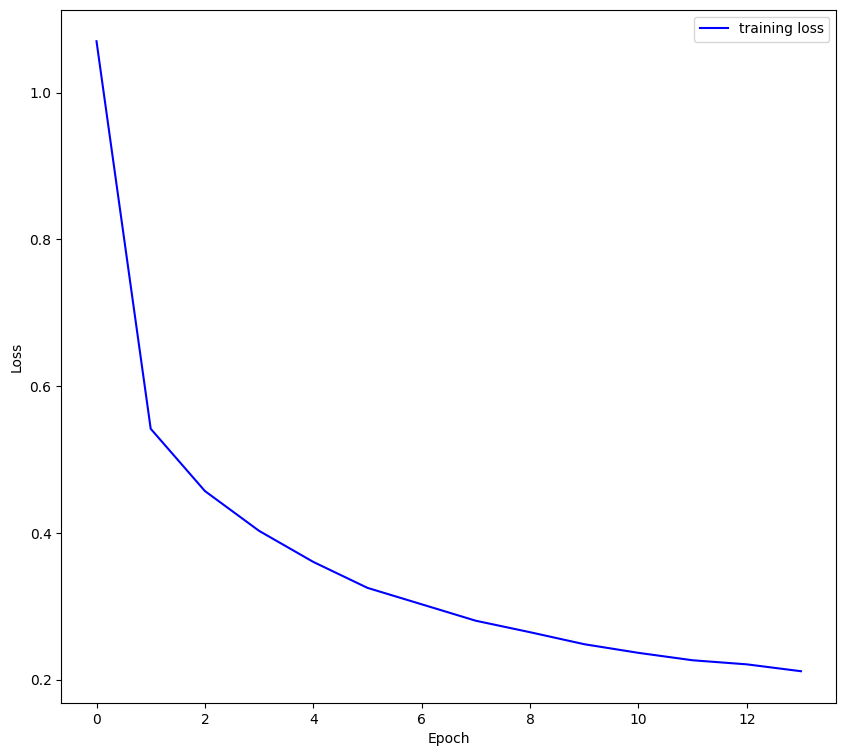

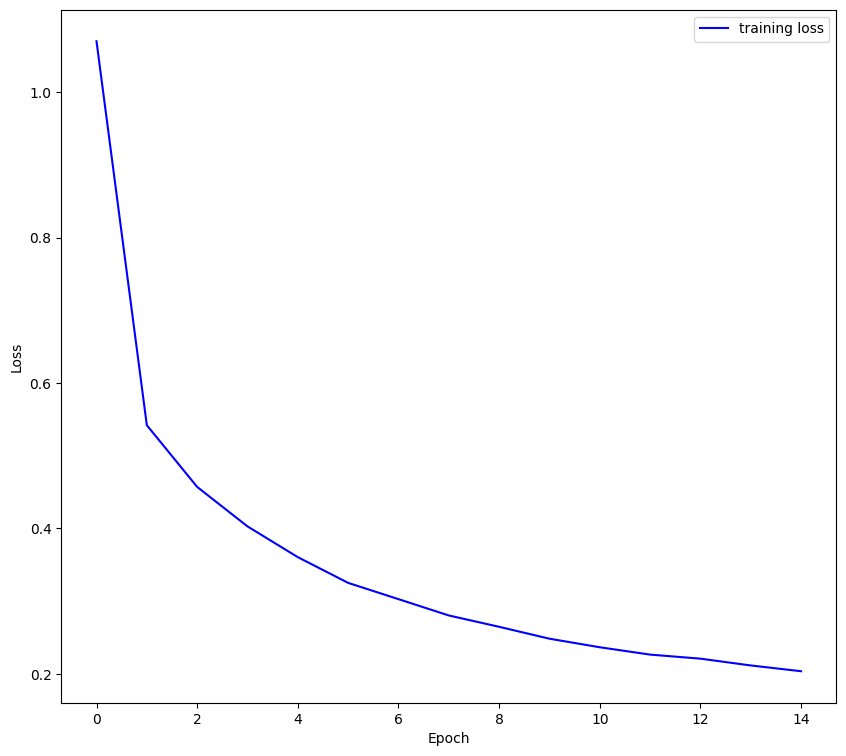

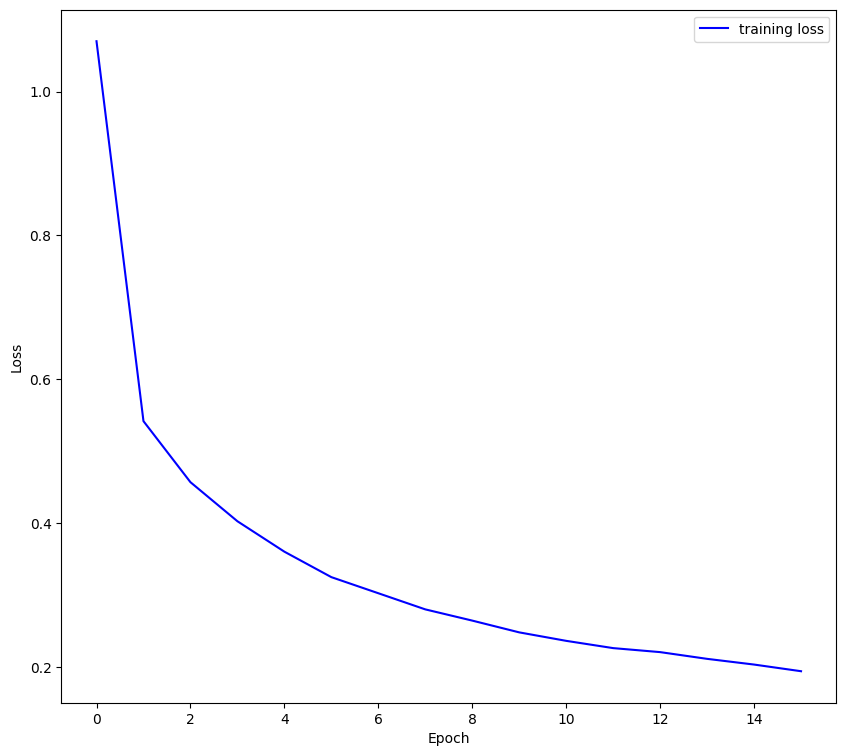

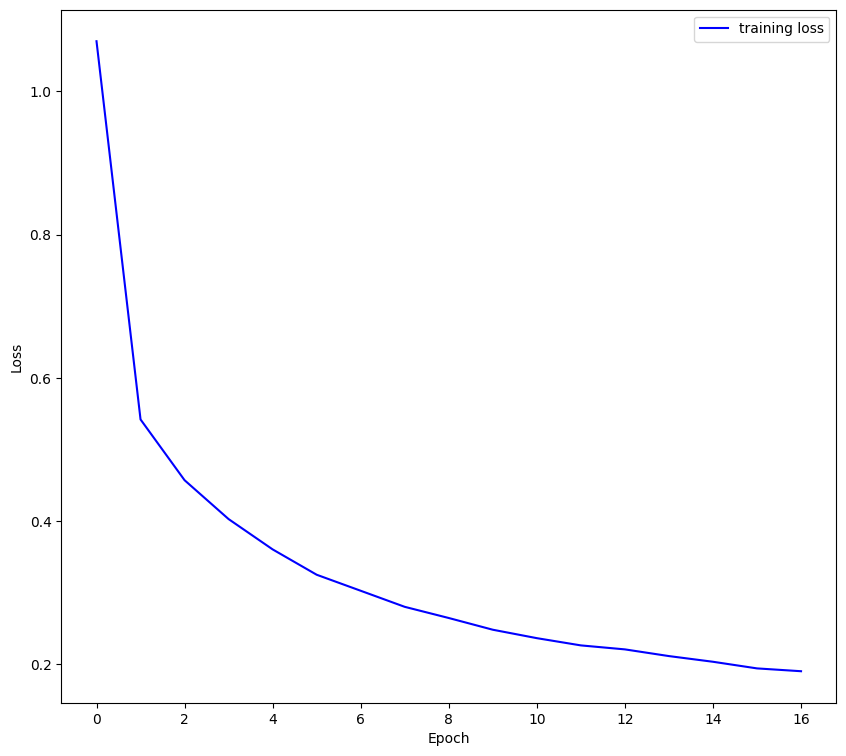

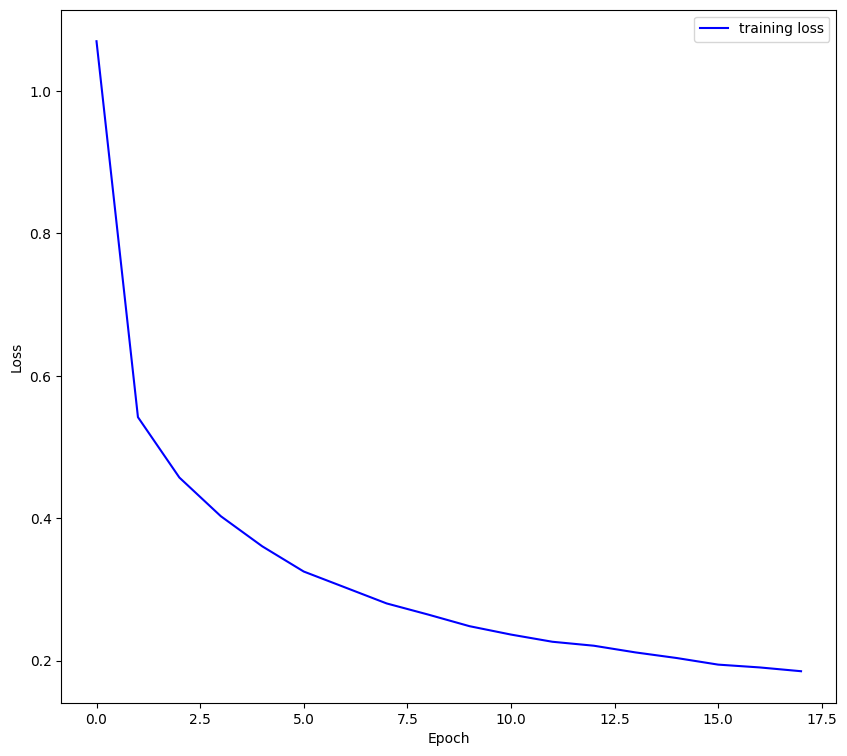

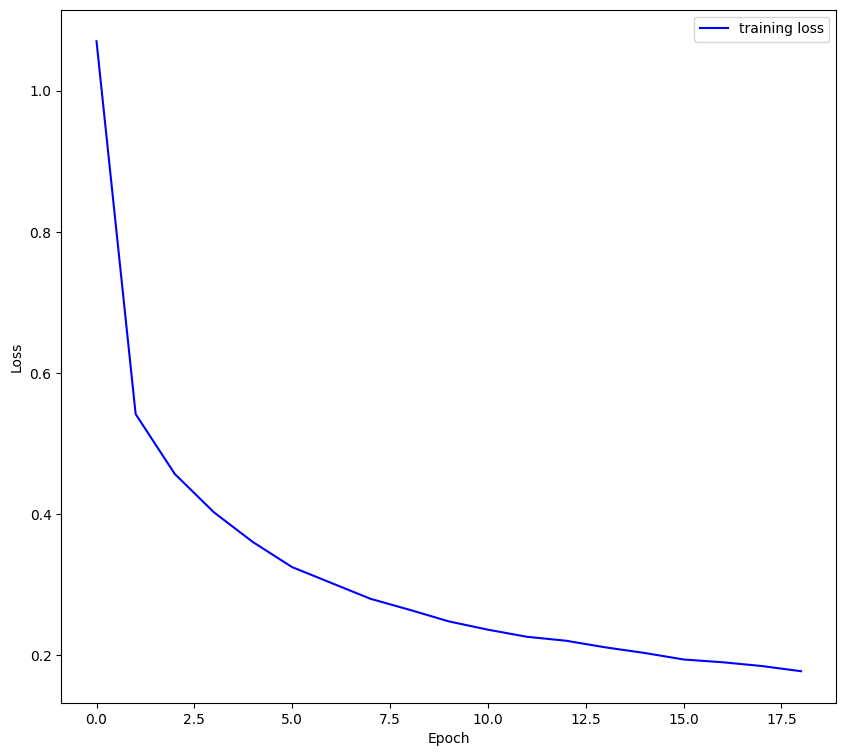

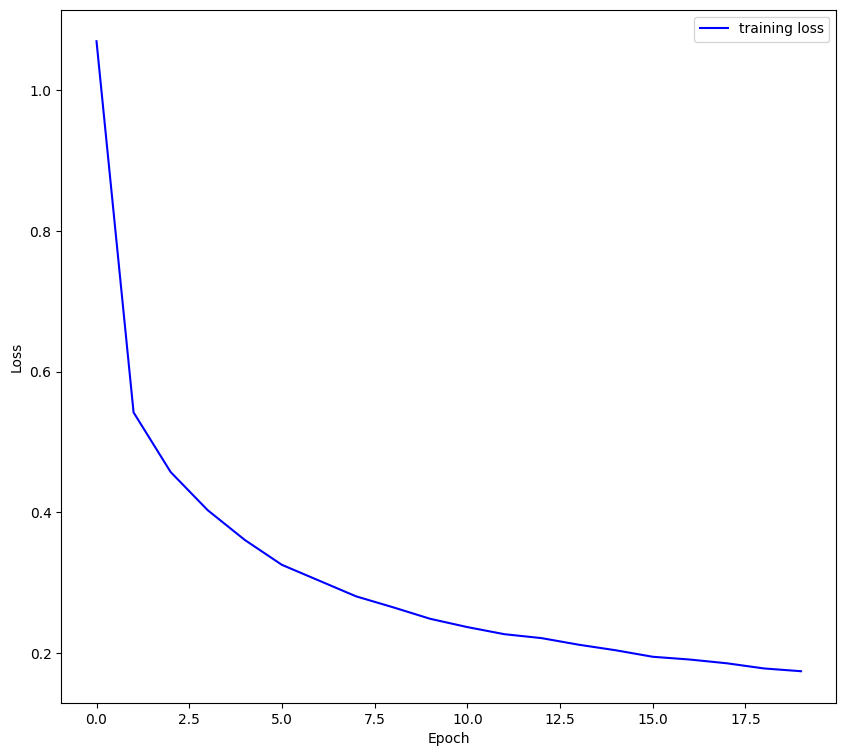

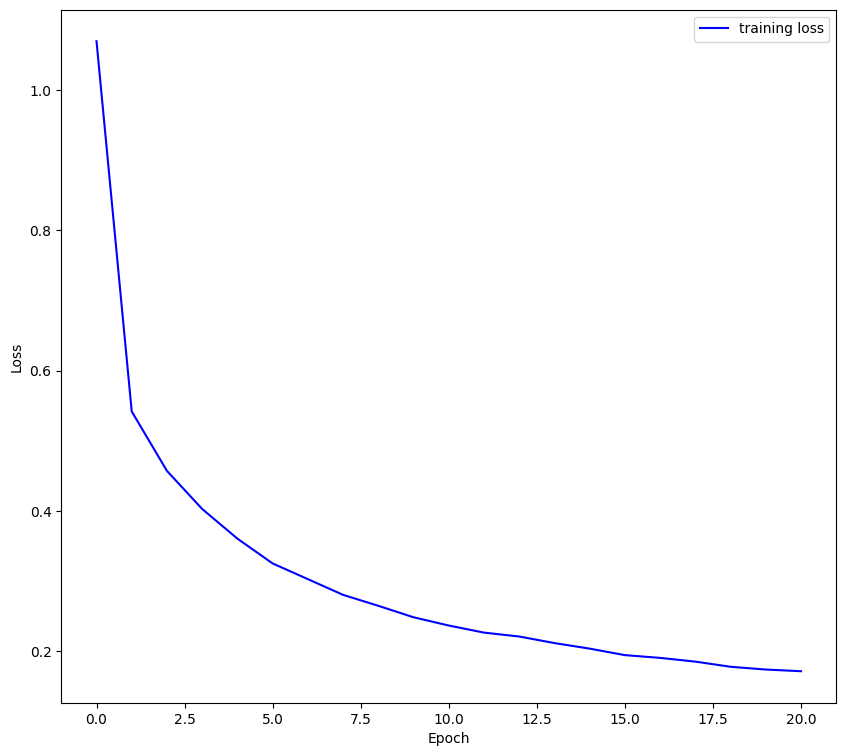

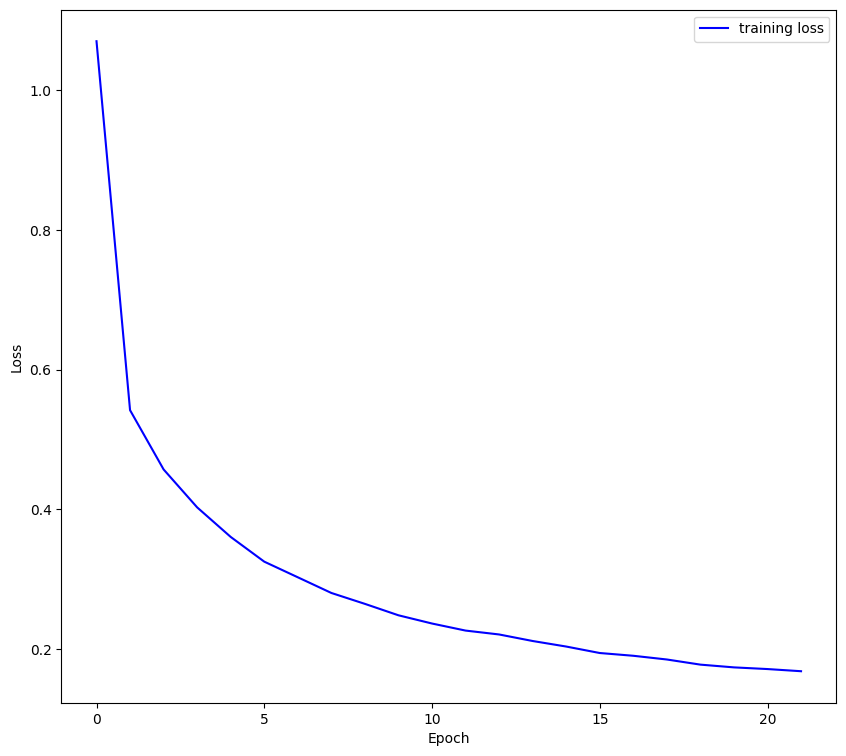

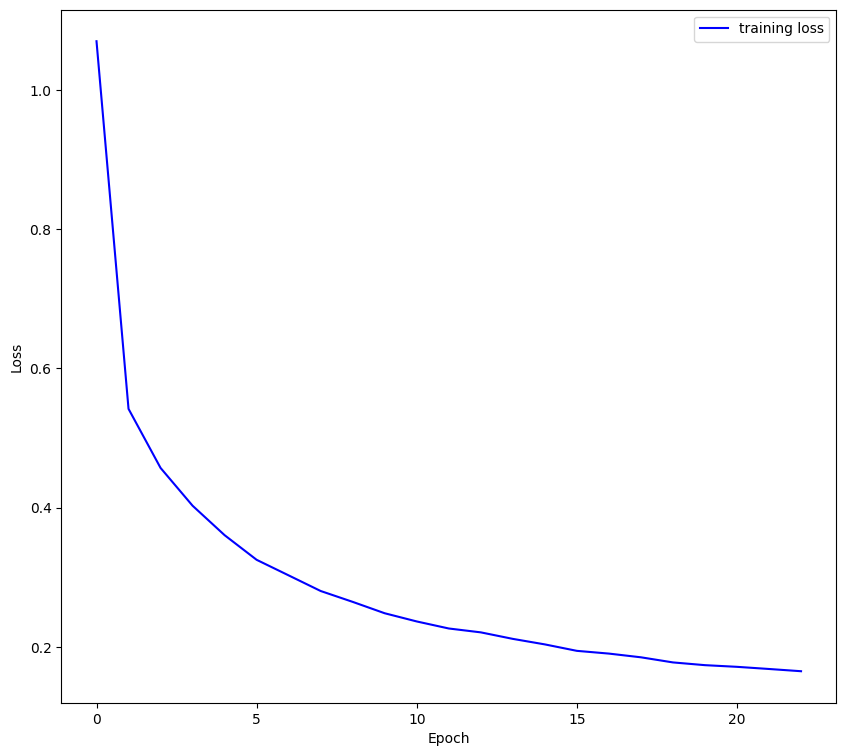

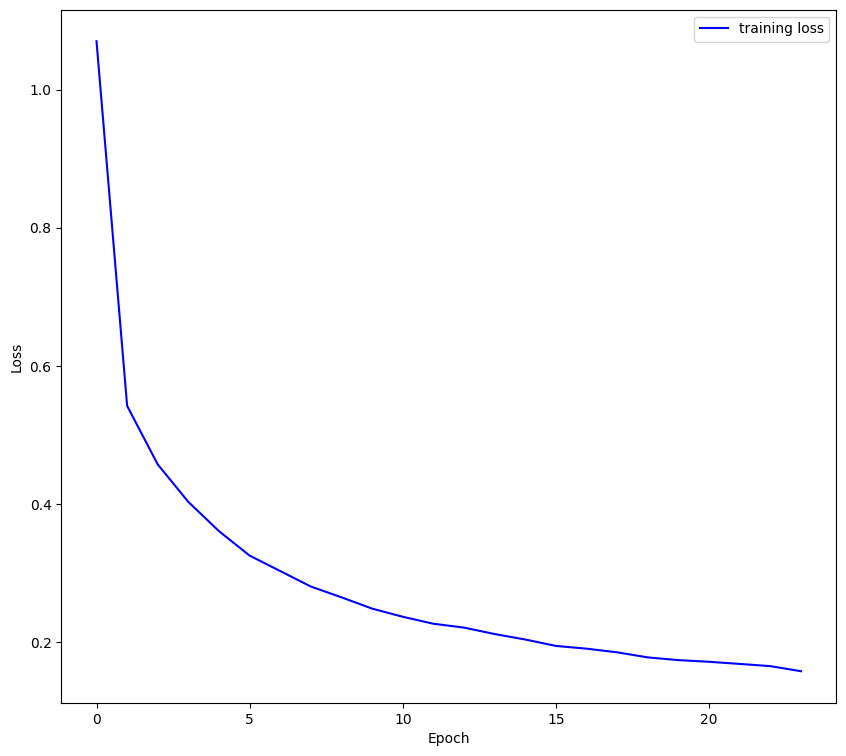

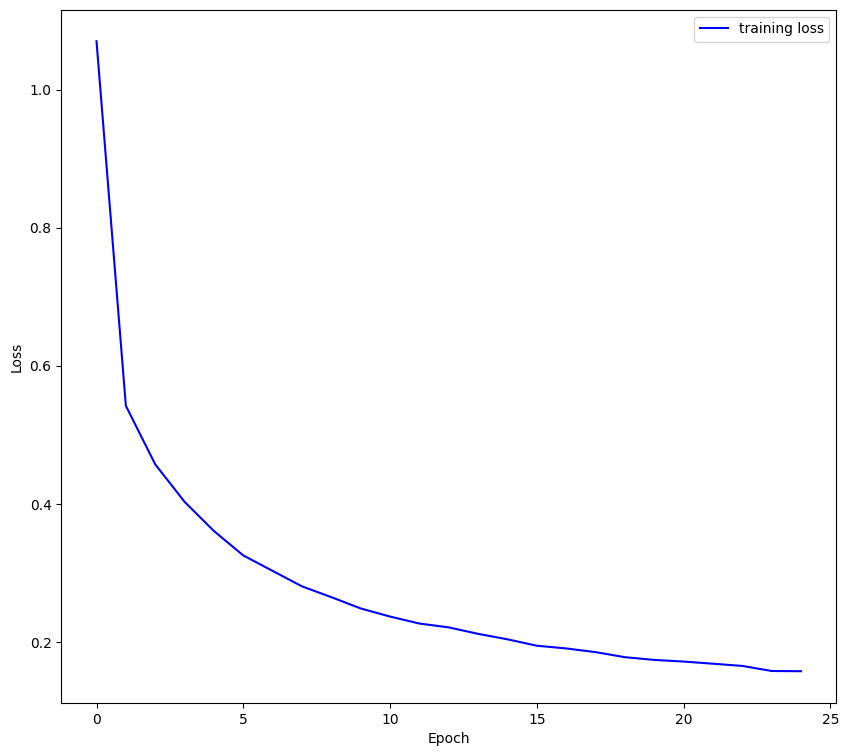

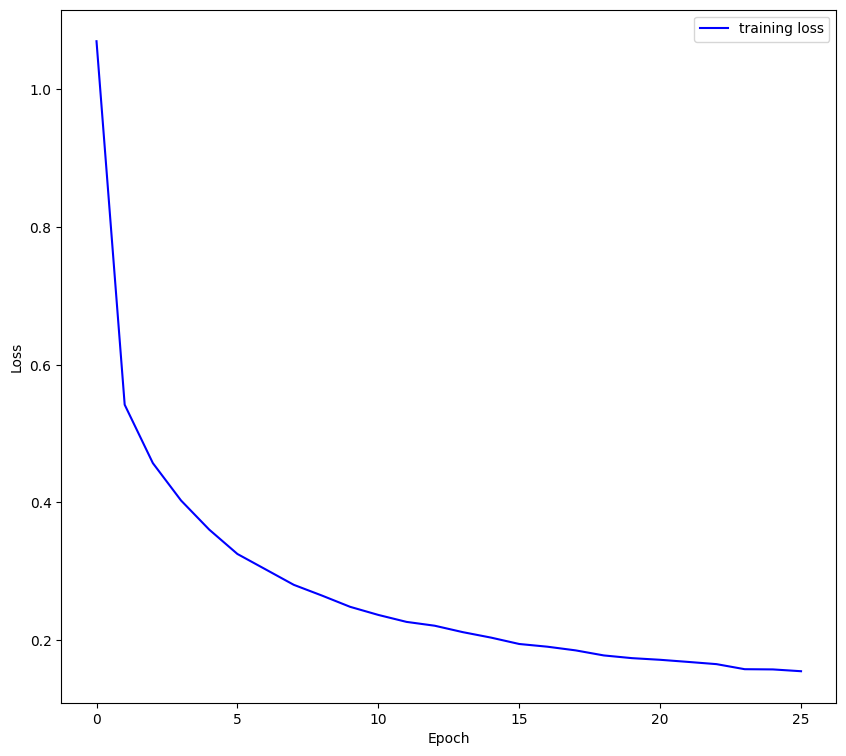

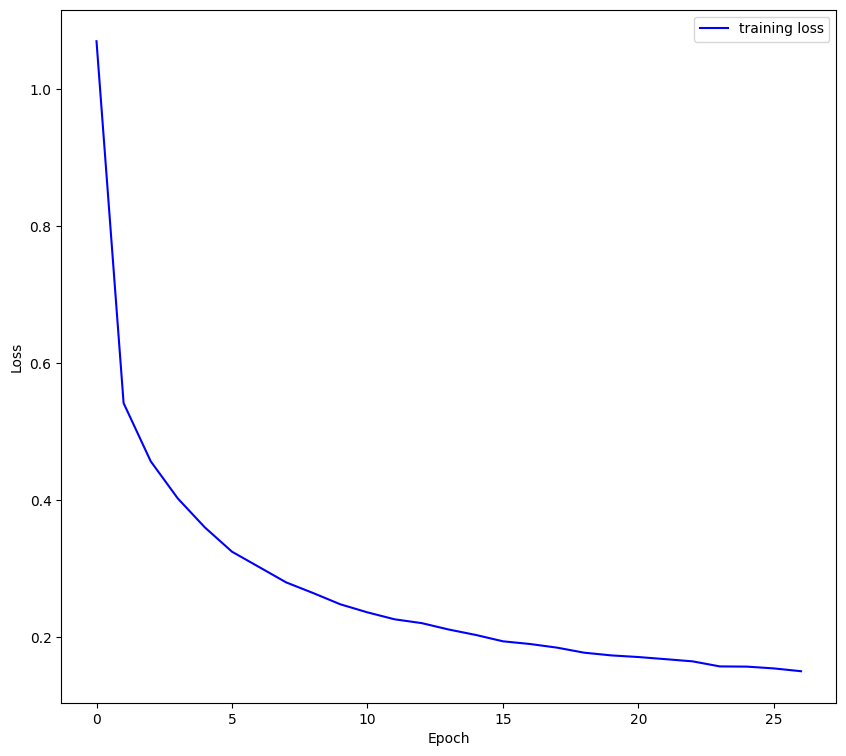

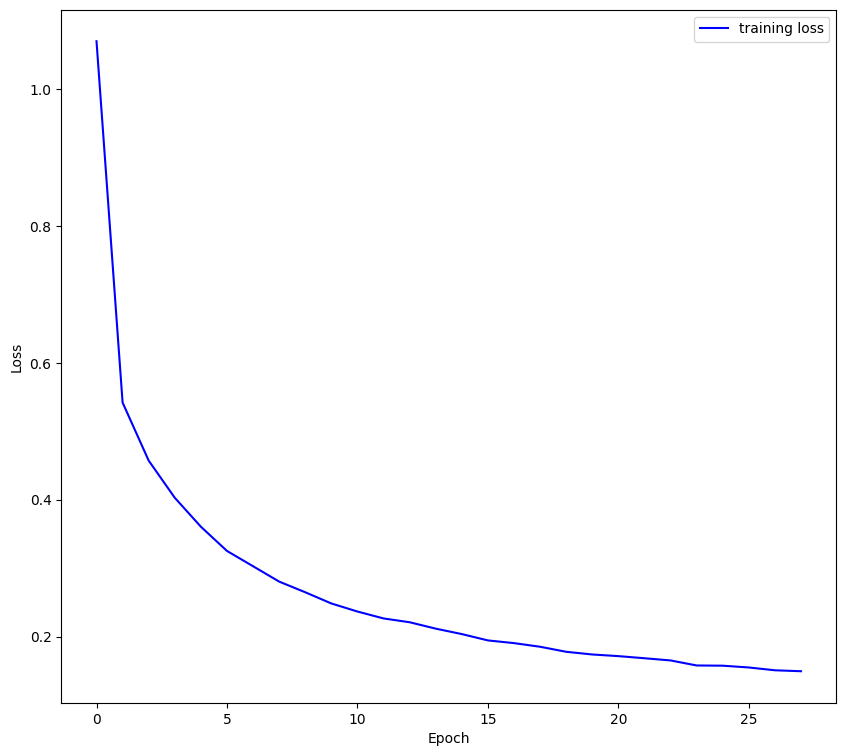

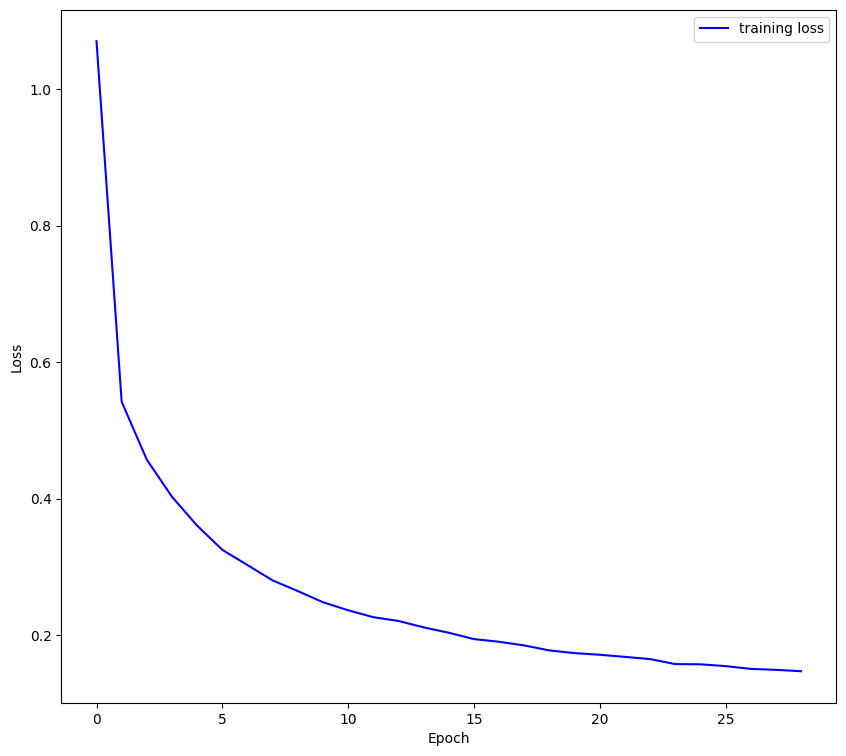

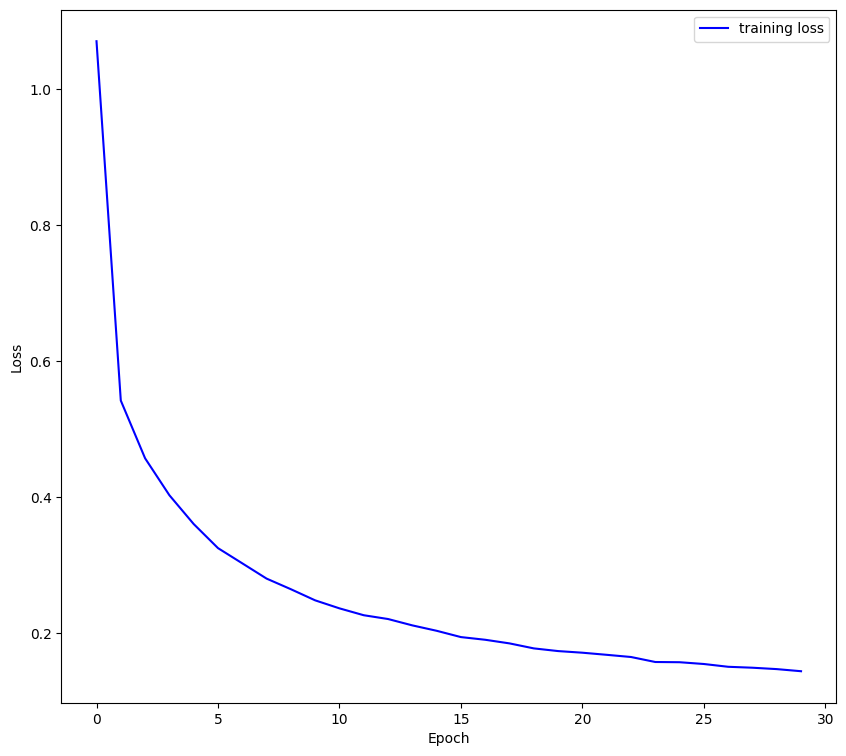

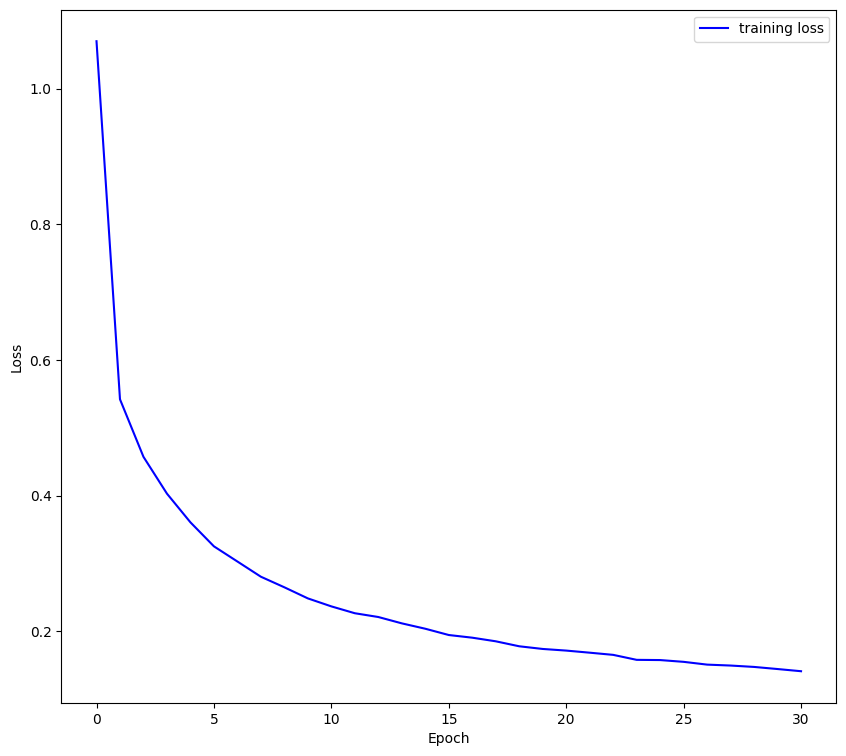

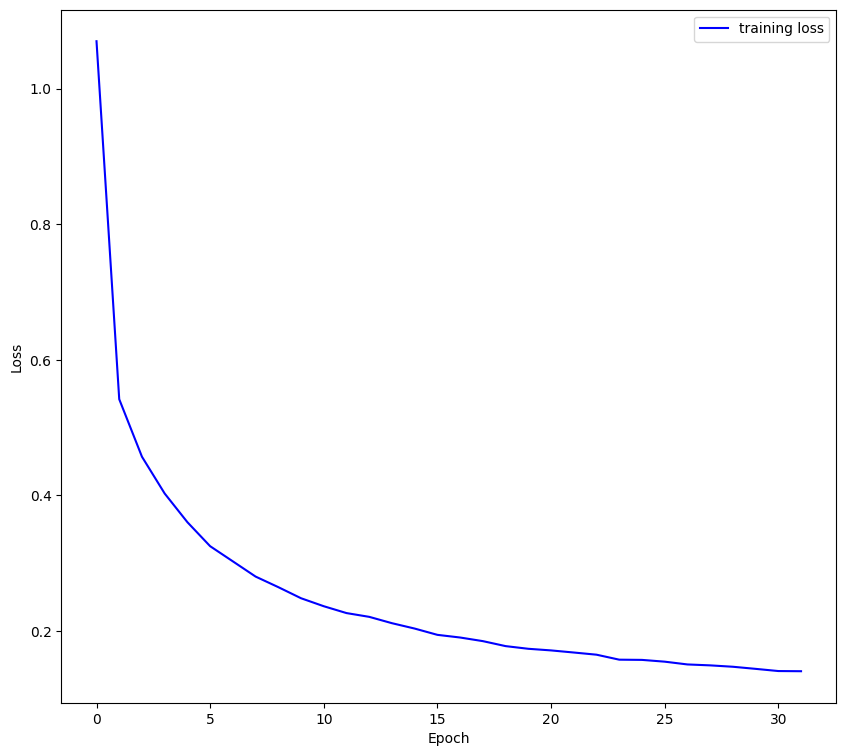

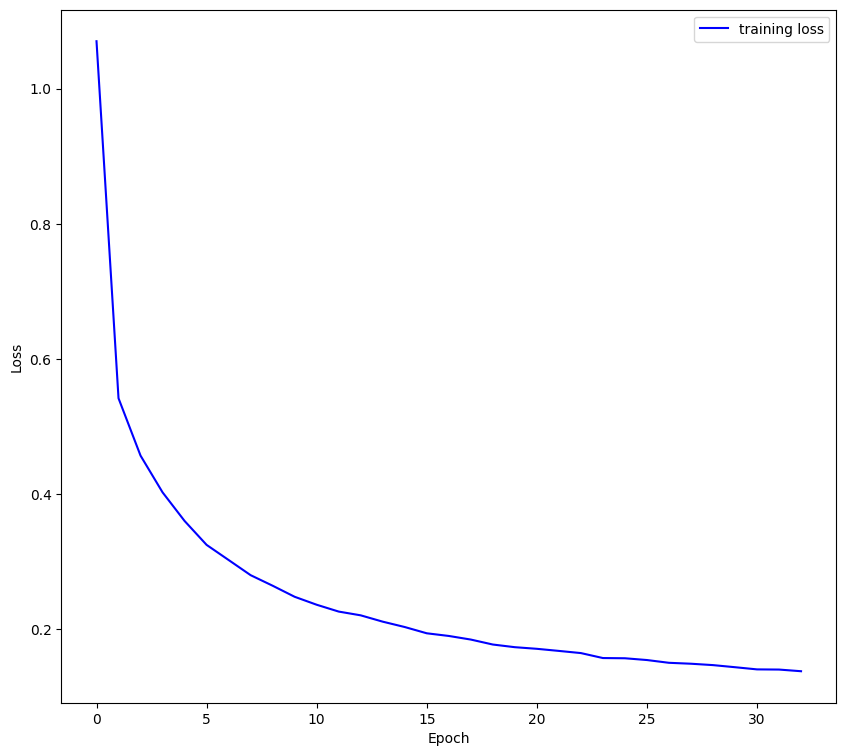

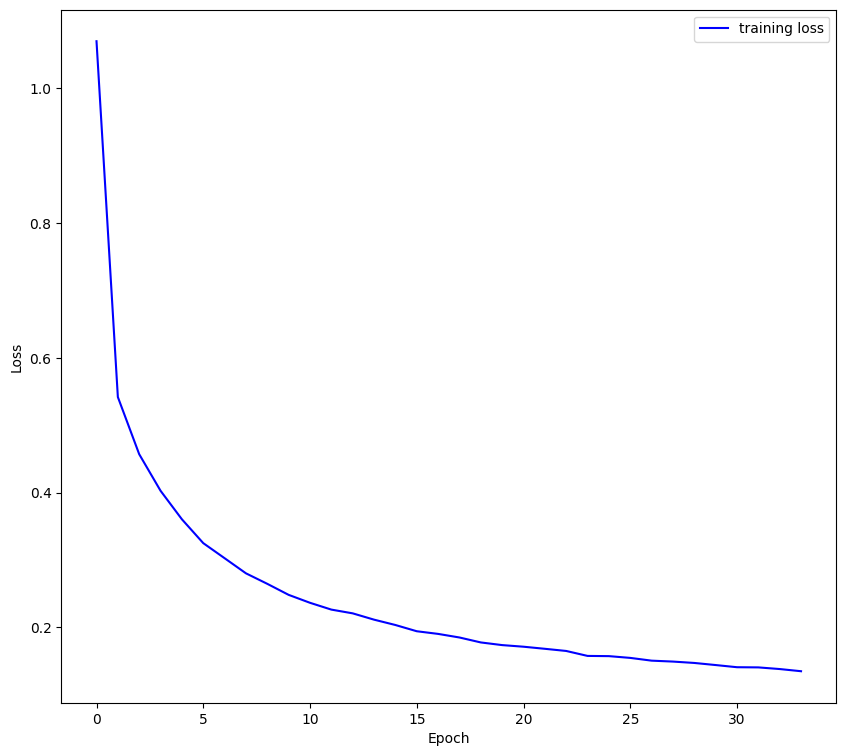

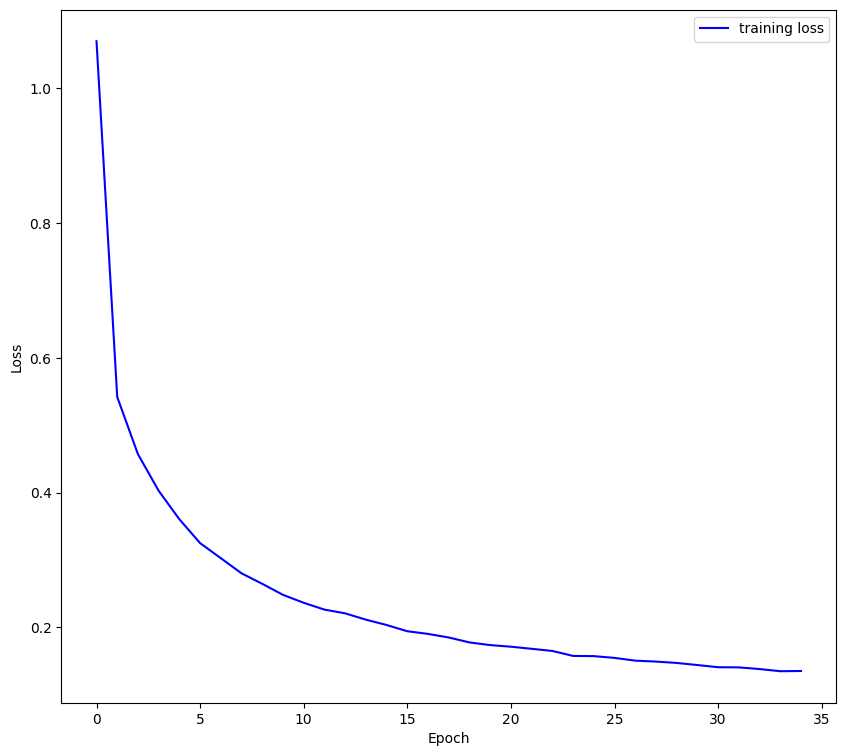

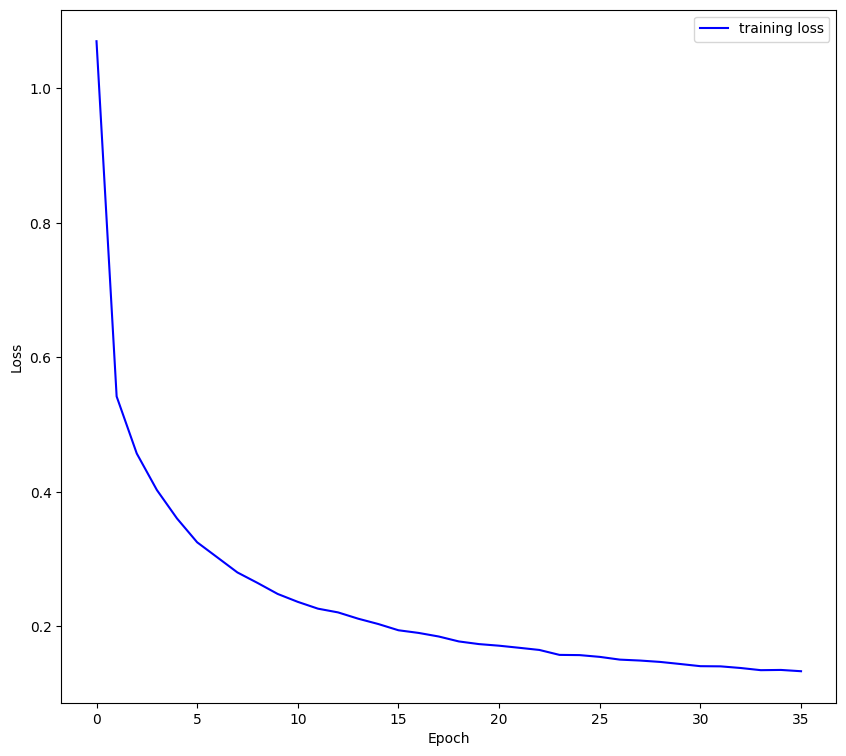

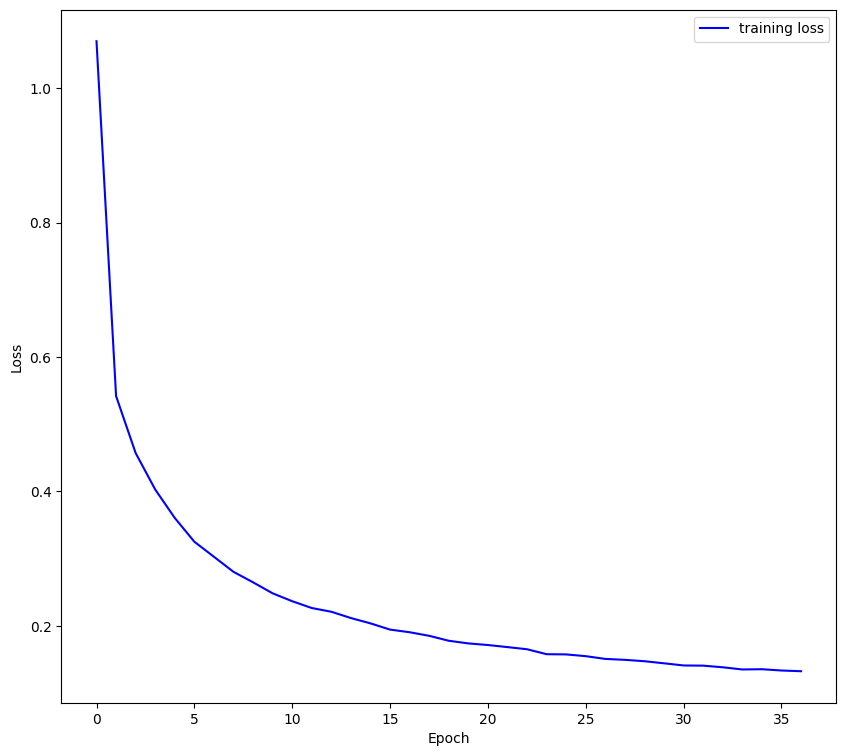

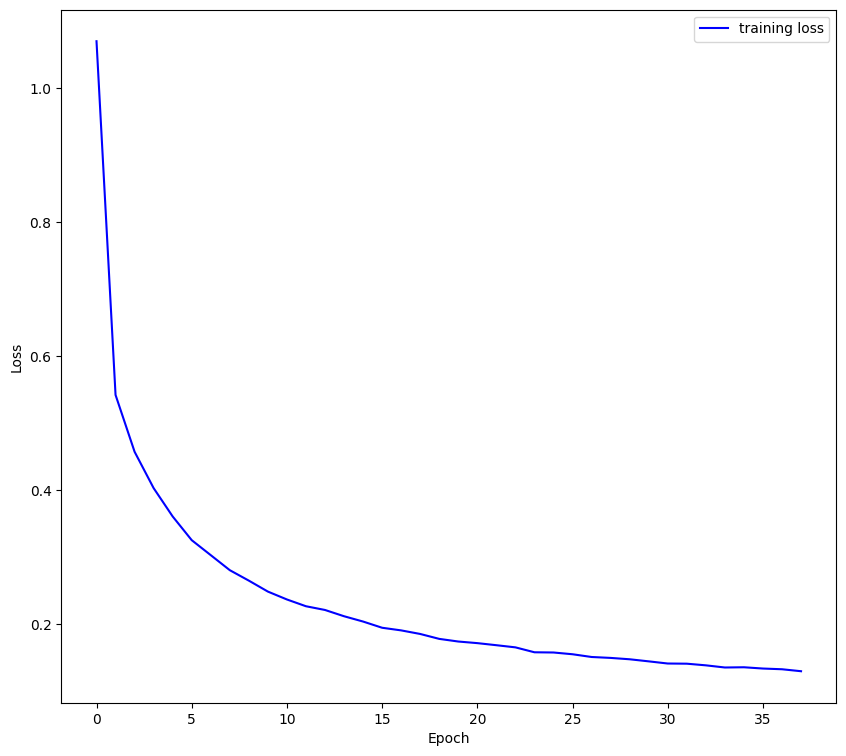

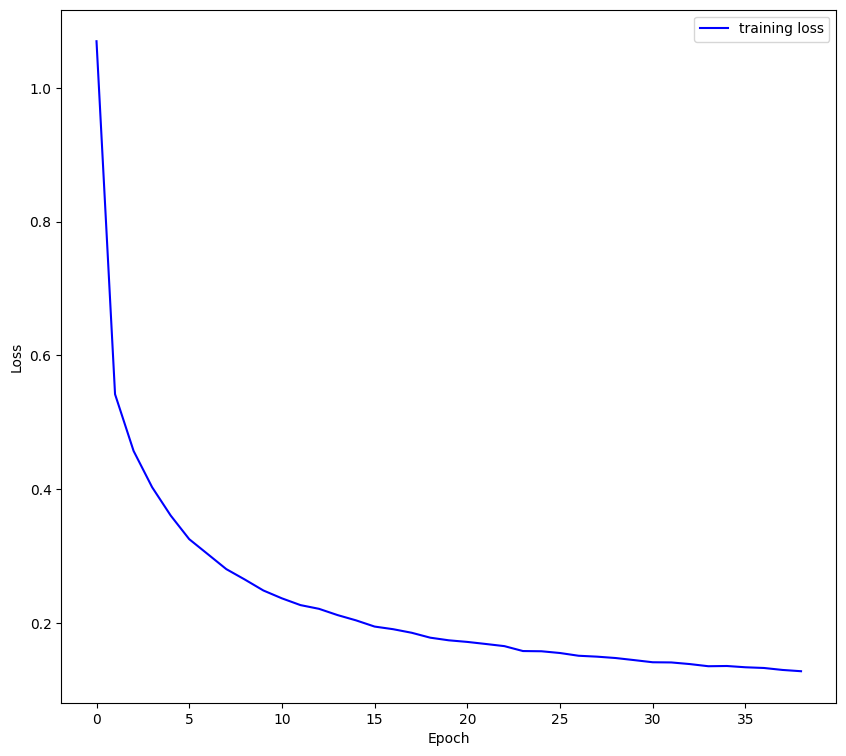

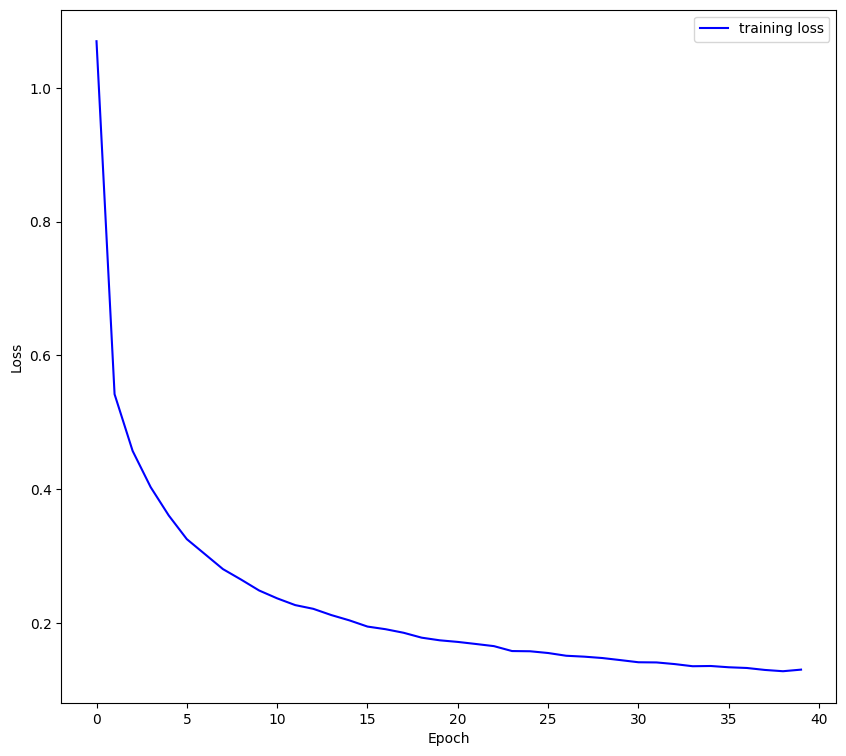

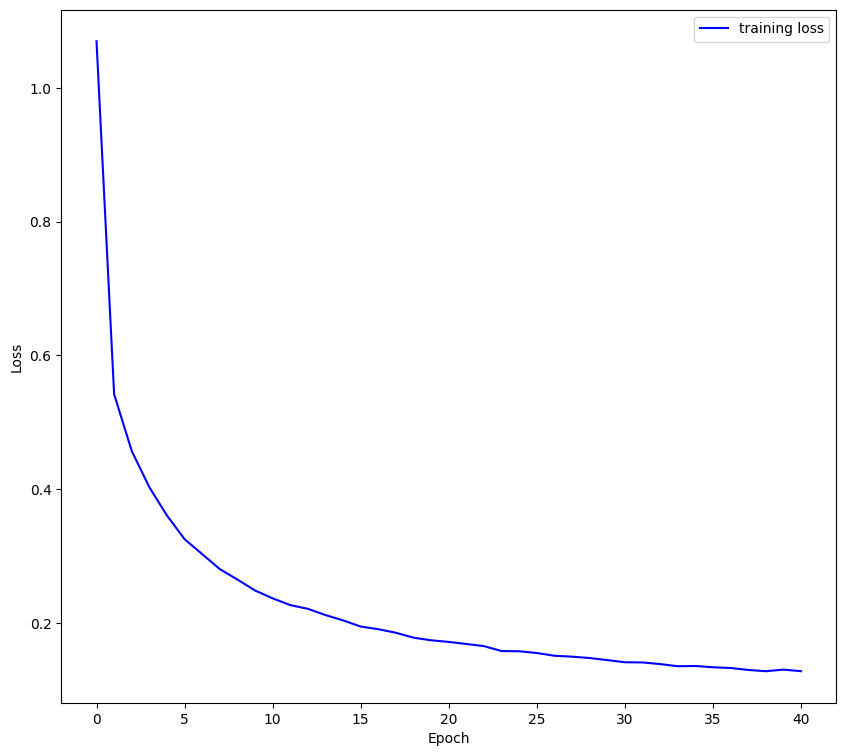

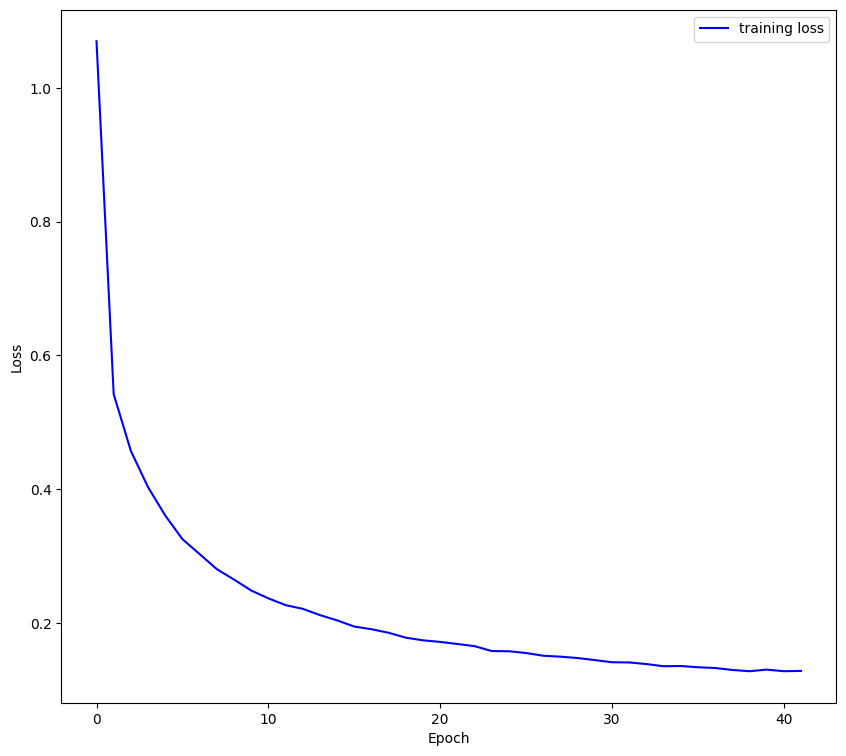

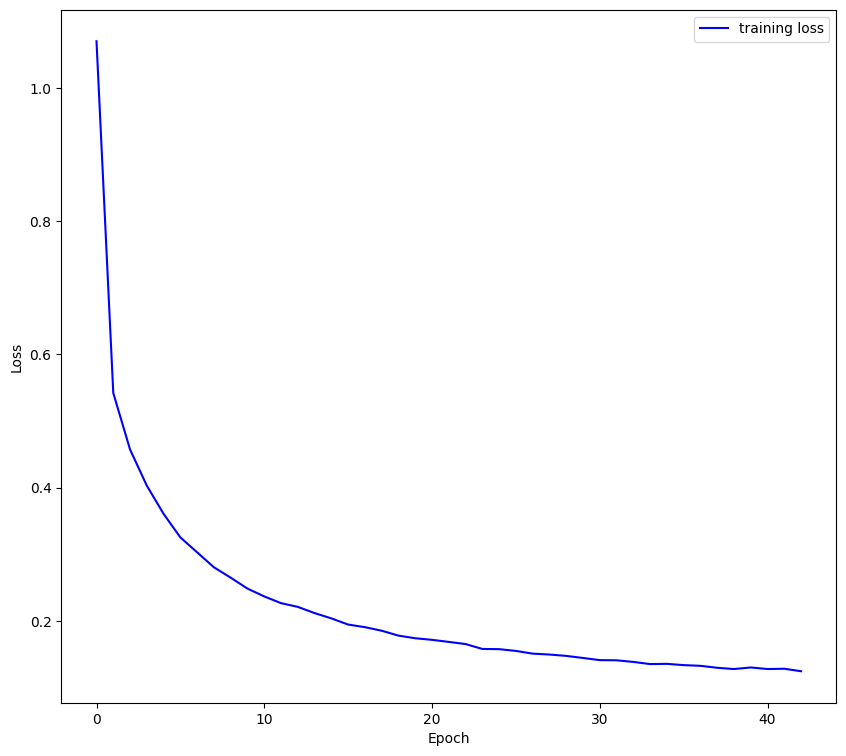

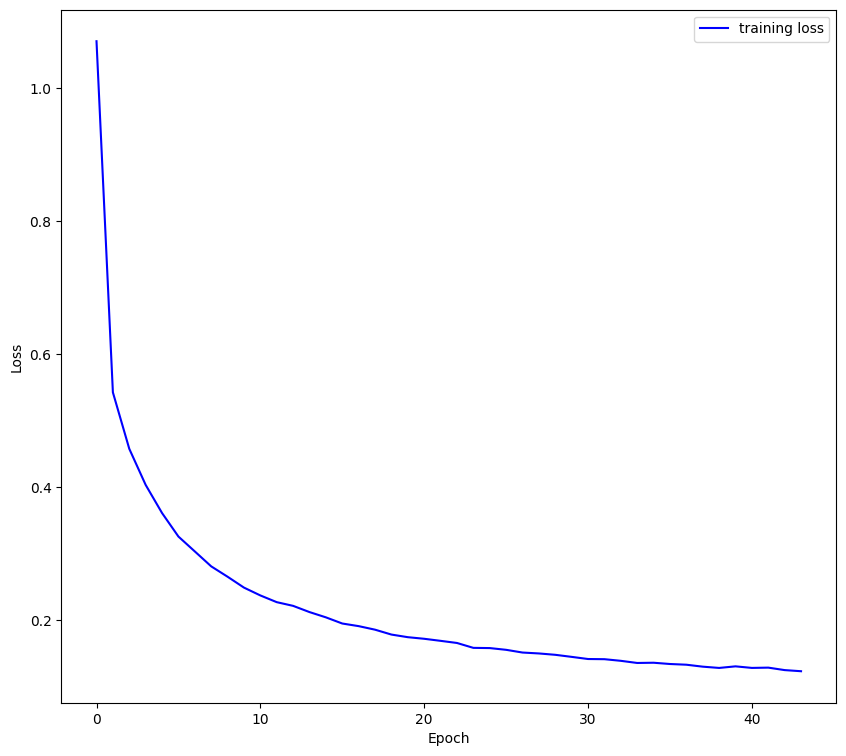

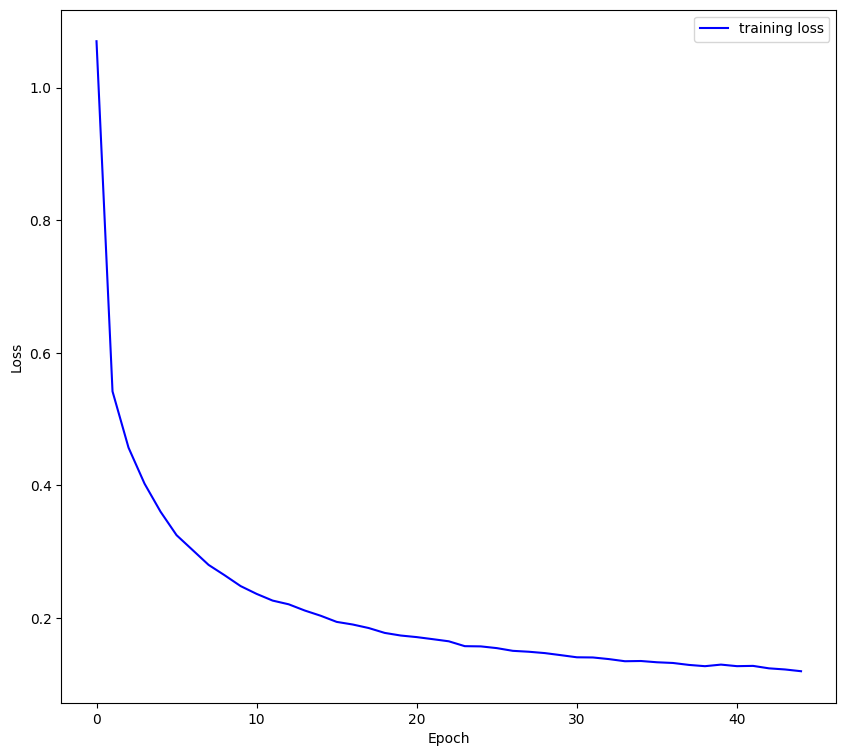

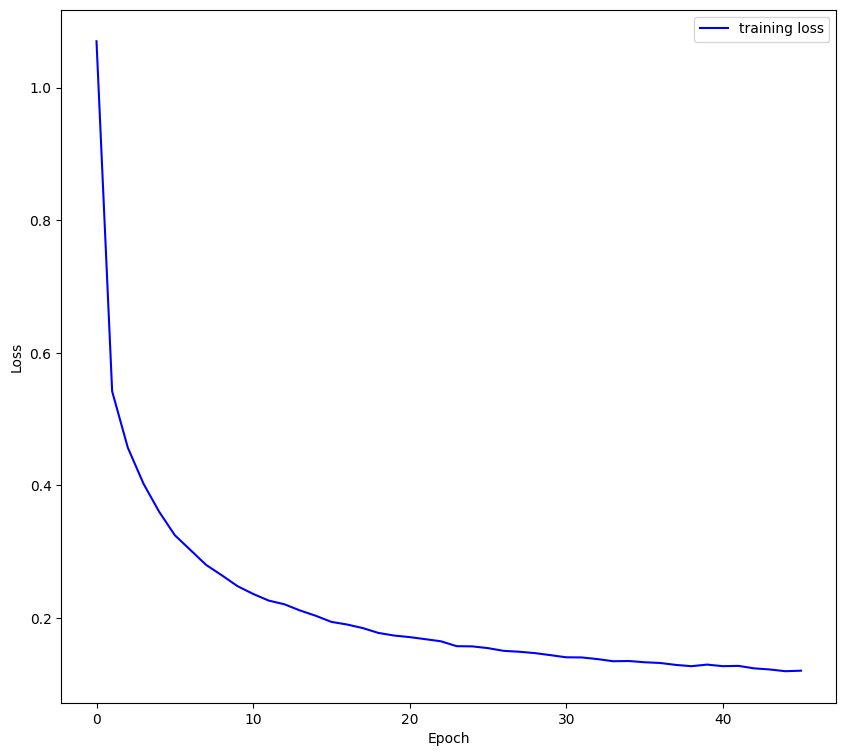

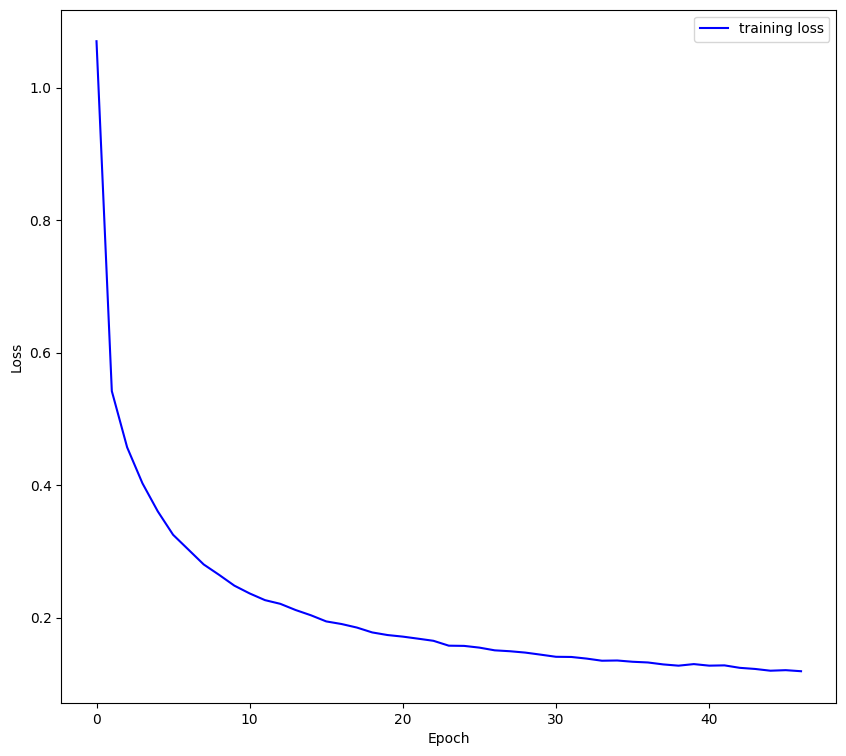

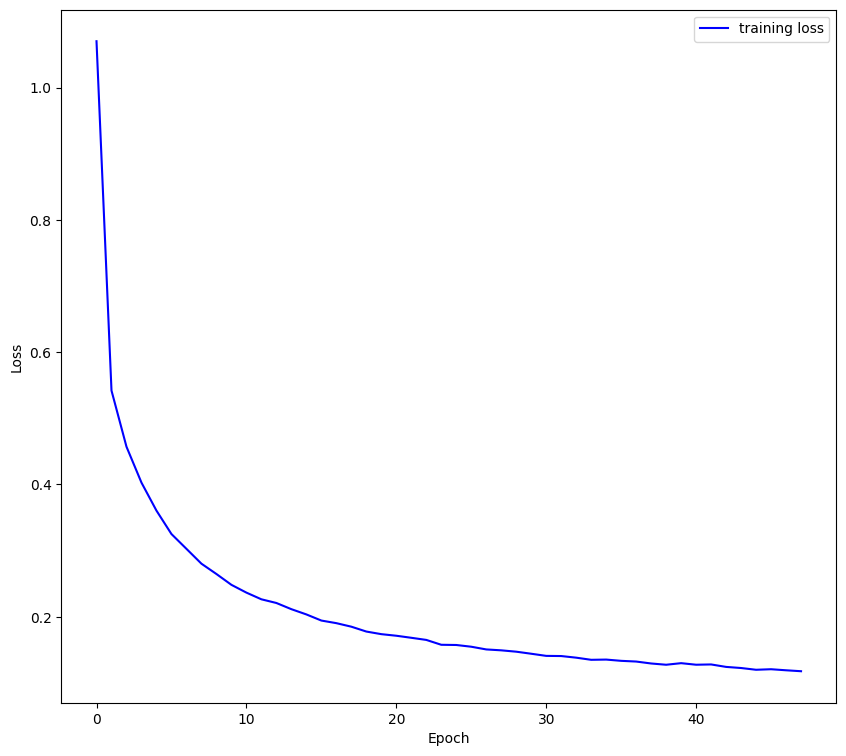

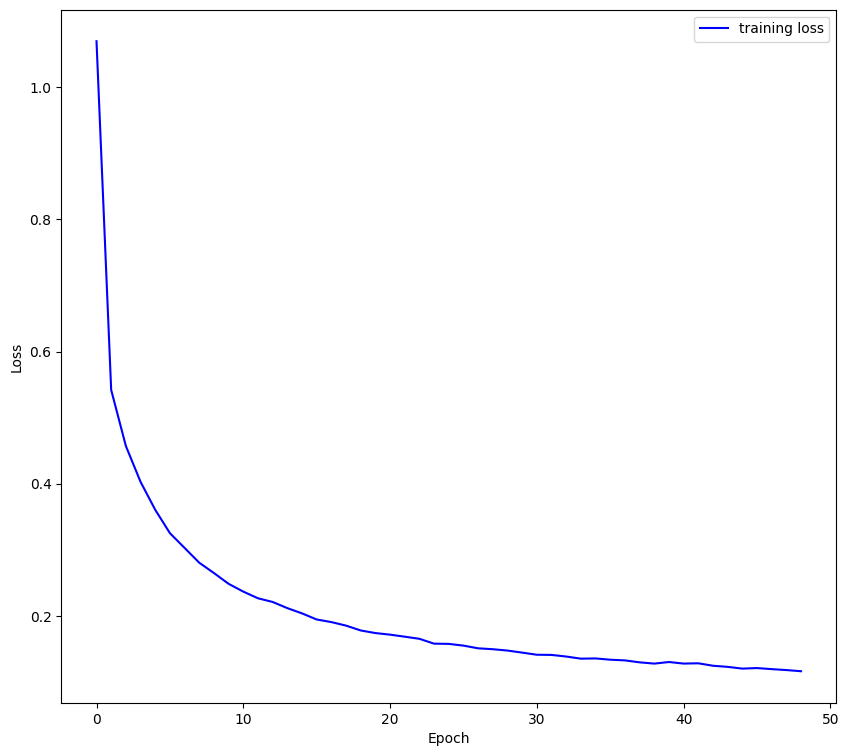

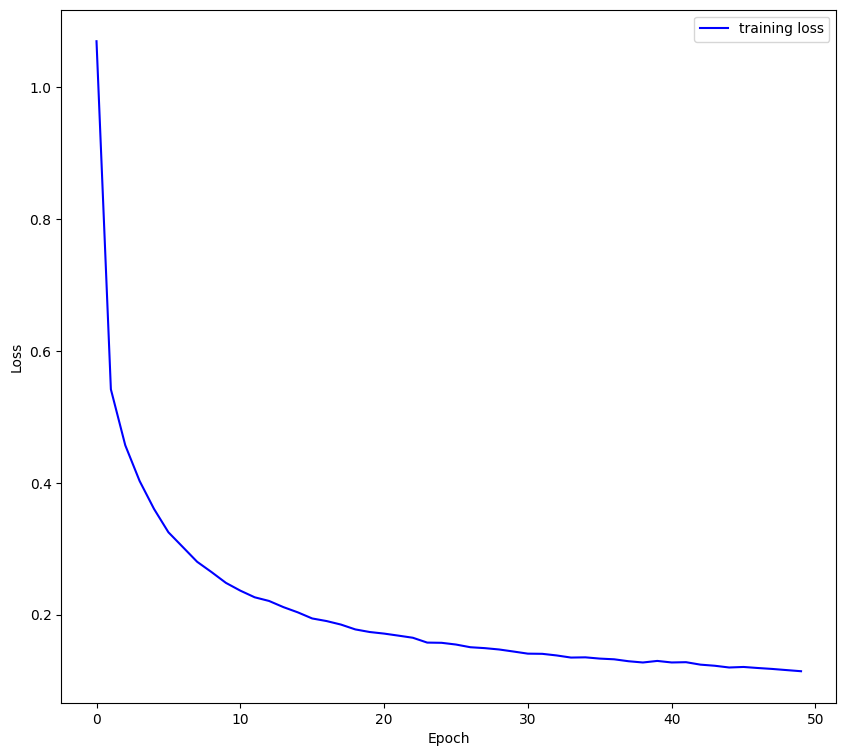

In [7]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
objective = nn.CrossEntropyLoss()
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, objective, epoch)

## Evaluation

### Model Ensemble

In [8]:
def test():
    net.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
    print('Accuracy: {}/{}'.format(correct, TEST_SIZE))

net = torch.load("Dropout_49_0.114.pth").to(DEVICE)
test()

Accuracy: 9827/10000


## Weight Distribution

torch.Size([500, 784])
torch.Size([500, 500])
torch.Size([10, 500])
torch.Size([500])
torch.Size([500])
torch.Size([10])
648010


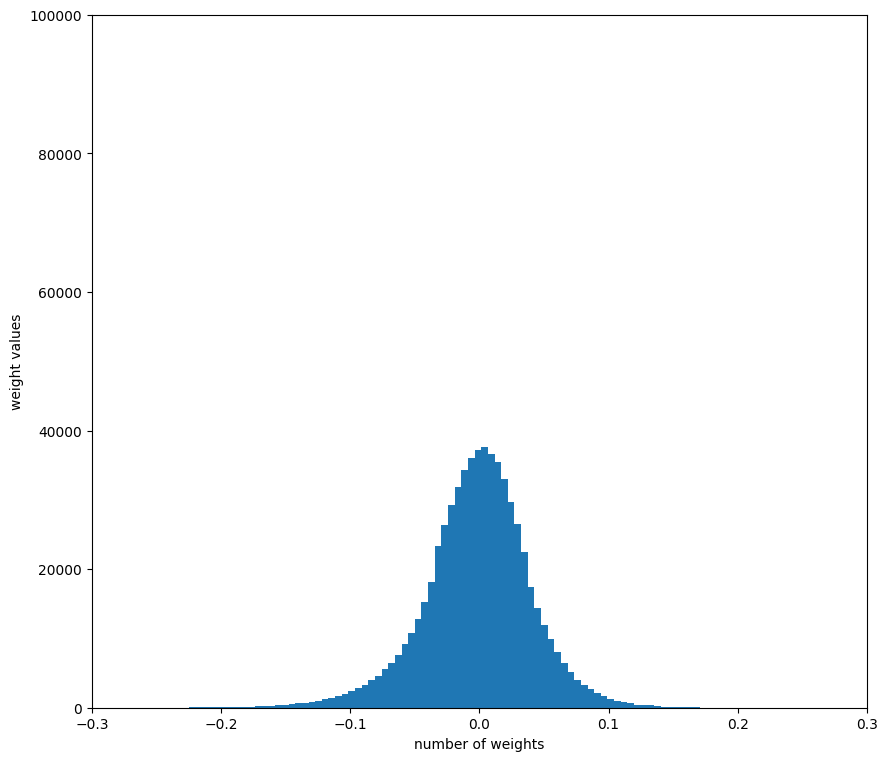

In [10]:
net = torch.load("Dropout_49_0.114.pth")

weight1 = net.l1.weight
bias1 = net.l1.bias

weight2 = net.l2.weight
bias2 = net.l2.bias

weight3 = net.l3.weight
bias3 = net.l3.bias

params = [weight1, weight2, weight3, bias1, bias2, bias3]
all_params = []

for param in params:
    print(param.shape)
    tlist = torch.flatten(param.cpu()).tolist()
    all_params += tlist

print(len(all_params))

plt.figure(figsize=(10,9))
plt.hist(all_params, bins=100)
plt.ylabel('weight values')
plt.xlabel('number of weights')
plt.xlim(-0.3, 0.3)
plt.ylim(0, 100000)
plt.savefig(f'./{NAME}_weight dist.png')

## Pruning

In [13]:
import torch.nn.utils.prune as prune

net = torch.load("Dropout_49_0.114.pth").to(DEVICE)

weight1 = net.l1.weight
bias1 = net.l1.bias

weight2 = net.l2.weight
bias2 = net.l2.bias

weight3 = net.l3.weight
bias3 = net.l3.bias

parameters_to_prune = (
    (net.l1, 'weight'),
    (net.l1, 'bias'),
    (net.l2, 'weight'),
    (net.l2, 'bias'),
    (net.l3, 'weight'),
    (net.l3, 'bias'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.9,
)

def test():
    net.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
    print('Accuracy: {}/{}'.format(correct, TEST_SIZE))

test()

Accuracy: 2216/10000
